<a href="https://colab.research.google.com/github/Omjagdal/GAN-CNN-project/blob/main/CNN%2BGAN_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
diagram = """
┌──────────────┐
Noise (z) ─────► │ Generator │ ─────► Fake Faces
└──────────────┘
        │
        ▼
┌──────────────────┐
│ Discriminator     │
└──────────────────┘

Real Faces ─────────────────────────┘


Fake + Real Faces ─────► VGG16 ─────►
        │                    │
        │                    ├─► Attribute Prediction (Option A)
        │                    │     Smiling / Male / Glasses
        │                    │
        │                    └─► Feature Embeddings (Option B)
        │                          Perceptual Similarity / FID
"""

with open("architecture.txt", "w") as f:
    f.write(diagram)

print("architecture.txt created successfully")


architecture.txt created successfully


In [ ]:
print(diagram)



┌──────────────┐
Noise (z) ─────► │ Generator │ ─────► Fake Faces
└──────────────┘
        │
        ▼
┌──────────────────┐
│ Discriminator     │
└──────────────────┘

Real Faces ─────────────────────────┘


Fake + Real Faces ─────► VGG16 ─────►
        │                    │
        │                    ├─► Attribute Prediction (Option A)
        │                    │     Smiling / Male / Glasses
        │                    │
        │                    └─► Feature Embeddings (Option B)
        │                          Perceptual Similarity / FID



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import save_image

In [ ]:
!pip install -q kaggle
!pip install kaggle tensorflow opencv-python tqdm

!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/jangedoo/utkface-new'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omj
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


100%|██████████| 331M/331M [00:00<00:00, 718MB/s]


In [ ]:
import os

DATA_DIR = '/content/utkface-new'
print(os.listdir(DATA_DIR))

['utkface_aligned_cropped', 'UTKFace', 'crop_part1']


In [ ]:
print(os.listdir(DATA_DIR+'/UTKFace')[:10])

['22_1_4_20170103225134240.jpg.chip.jpg', '32_0_0_20170116224730121.jpg.chip.jpg', '36_1_0_20170104174248859.jpg.chip.jpg', '52_0_0_20170117161042224.jpg.chip.jpg', '66_1_0_20170110131727840.jpg.chip.jpg', '26_0_1_20170116010530676.jpg.chip.jpg', '26_0_0_20170117172856799.jpg.chip.jpg', '17_0_0_20170104003852806.jpg.chip.jpg', '59_0_0_20170111203739692.jpg.chip.jpg', '50_0_3_20170119205531336.jpg.chip.jpg']


In [ ]:
import torchvision.transforms as T

image_size = 64

transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        all_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]
        self.images = []
        for img_name in all_files:
            # Filenames are typically like: age_gender_race_datetime.jpg
            # We need at least 4 parts when splitting by '_'
            parts = img_name.split('_')
            if len(parts) >= 4:
                try:
                    # Validate if age, gender, race are integers
                    int(parts[0]) # age
                    int(parts[1]) # gender
                    int(parts[2]) # race
                    self.images.append(img_name)
                except ValueError:
                    # Skip filenames where age, gender, or race are not integers
                    # print(f"Skipping malformed filename (non-integer metadata): {img_name}")
                    pass
            else:
                # Skip filenames that do not have enough parts
                # print(f"Skipping malformed filename (too few underscores): {img_name}")
                pass
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        # This line should now be safe because malformed filenames are filtered in __init__
        age, gender, race, _ = img_name.split("_", 3)

        age = int(age)
        gender = int(gender)  # 0=Male, 1=Female
        race = int(race)

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, age, gender, race

In [ ]:
from torch.utils.data import DataLoader

dataset = UTKFaceDataset(DATA_DIR + '/UTKFace', transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

print("Total images:", len(dataset))

Total images: 23705


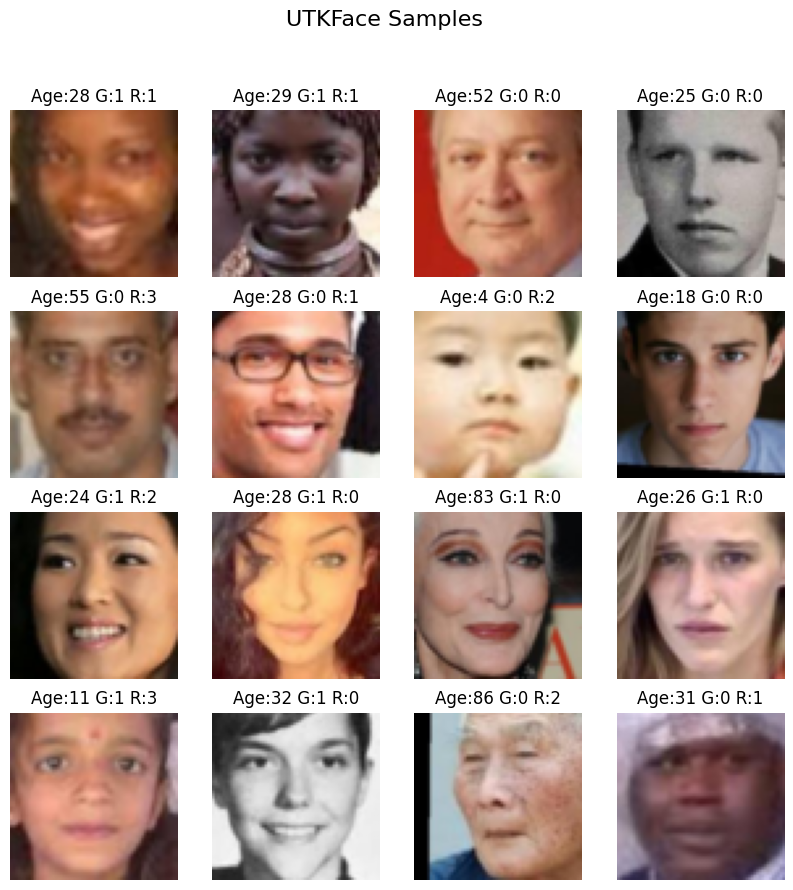

In [ ]:
import matplotlib.pyplot as plt

images, ages, genders, races = next(iter(dataloader))
images = (images + 1) / 2  # [-1,1] → [0,1]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("UTKFace Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Age:{ages[i]} G:{genders[i]} R:{races[i]}")

plt.show()


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),

            nn.Unflatten(1, (256, 8, 8)),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8 → 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16 → 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 32 → 64
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)



In [ ]:

z_dim = 100
G = Generator(z_dim).to(device)

print("Generator on:", next(G.parameters()).device)


Generator on: cuda:0


In [ ]:
z = torch.randn(4, z_dim, device=device)
fake_images = G(z)

print("Fake images shape:", fake_images.shape)
print("Fake images device:", fake_images.device)


Fake images shape: torch.Size([4, 3, 64, 64])
Fake images device: cuda:0


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # 64×64 → 32×32
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # 32×32 → 16×16
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 16×16 → 8×8
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
D = Discriminator().to(device)

print("Discriminator on:", next(D.parameters()).device)


Discriminator on: cuda:0


In [ ]:
test_out = D(fake_images)
print("Output shape:", test_out.shape)
print("Output device:", test_out.device)


Output shape: torch.Size([4, 1])
Output device: cuda:0


In [ ]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
print("Generator device:", next(G.parameters()).device)
print("Discriminator device:", next(D.parameters()).device)


Generator device: cuda:0
Discriminator device: cuda:0


In [ ]:
%%time


epochs = 30
z_dim = 100

G.train()
D.train()

for epoch in range(epochs):
    for real_imgs, _, _, _ in dataloader:

        # ======================
        # Move data to GPU
        # ======================
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ======================
        # Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Real images
        real_output = D(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        # Fake images
        z = torch.randn(batch_size, z_dim, device=device)
        fake_imgs = G(z)

        fake_output = D(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # ======================
        # Train Generator
        # ======================
        optimizer_G.zero_grad()

        fake_output = D(fake_imgs)
        g_loss = criterion(fake_output, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/30] | D Loss: 0.1550 | G Loss: 4.4568
Epoch [2/30] | D Loss: 0.1019 | G Loss: 5.7167
Epoch [3/30] | D Loss: 1.7860 | G Loss: 10.1319
Epoch [4/30] | D Loss: 0.1244 | G Loss: 2.9827
Epoch [5/30] | D Loss: 0.1837 | G Loss: 3.5434
Epoch [6/30] | D Loss: 0.1462 | G Loss: 3.2056
Epoch [7/30] | D Loss: 0.9528 | G Loss: 1.1621
Epoch [8/30] | D Loss: 0.4524 | G Loss: 6.0831
Epoch [9/30] | D Loss: 0.1165 | G Loss: 3.8499
Epoch [10/30] | D Loss: 0.9066 | G Loss: 0.6300
Epoch [11/30] | D Loss: 0.2716 | G Loss: 3.6338
Epoch [12/30] | D Loss: 0.0549 | G Loss: 4.0995
Epoch [13/30] | D Loss: 9.7281 | G Loss: 9.2802
Epoch [14/30] | D Loss: 0.0211 | G Loss: 5.5332
Epoch [15/30] | D Loss: 0.1196 | G Loss: 4.0565
Epoch [16/30] | D Loss: 0.3789 | G Loss: 2.9273
Epoch [17/30] | D Loss: 0.0467 | G Loss: 3.8264
Epoch [18/30] | D Loss: 0.0907 | G Loss: 3.9047
Epoch [19/30] | D Loss: 0.0968 | G Loss: 4.1302
Epoch [20/30] | D Loss: 0.5628 | G Loss: 1.9727
Epoch [21/30] | D Loss: 0.0635 | G Loss: 4.4041


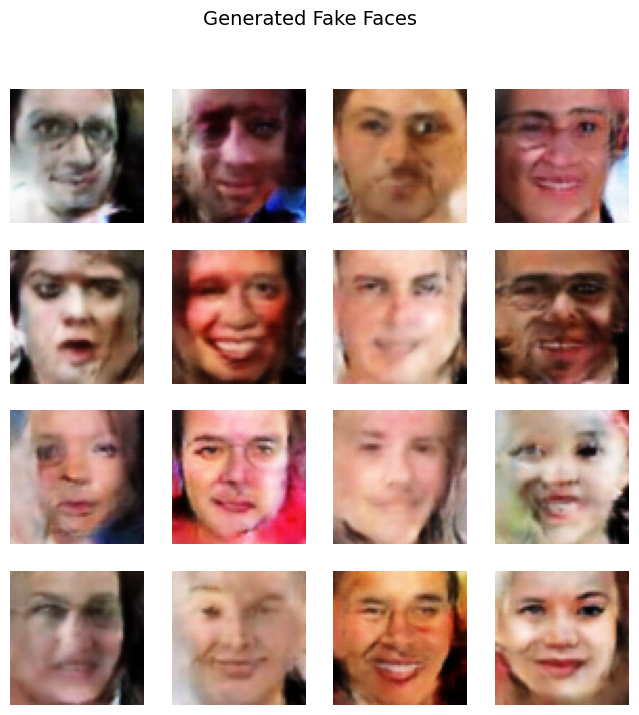

In [ ]:
import matplotlib.pyplot as plt

G.eval()  # evaluation mode

with torch.no_grad():
    z = torch.randn(16, z_dim, device=device)
    fake_imgs = G(z)

# Convert from [-1,1] → [0,1]
fake_imgs = (fake_imgs + 1) / 2
fake_imgs = fake_imgs.cpu()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Generated Fake Faces", fontsize=14)

for i, ax in enumerate(axes.flat):
    img = fake_imgs[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.axis("off")

plt.show()


In [ ]:
import torchvision.models as models
import torch.nn.functional as F

# Load pretrained VGG16
vgg = models.vgg16(pretrained=True).to(device)

# Remove classifier, keep feature extractor
vgg.classifier = nn.Identity()

# Freeze VGG weights
for param in vgg.parameters():
    param.requires_grad = False

vgg.eval()

print("VGG16 loaded on:", next(vgg.parameters()).device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 73.4MB/s]


VGG16 loaded on: cuda:0


In [ ]:
from torchvision import transforms

vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
def extract_vgg_features(images):
    """
    images: tensor in [-1,1], shape [B,3,64,64]
    returns: VGG feature embeddings
    """
    # [-1,1] → [0,1]
    images = (images + 1) / 2

    # Resize to 224x224
    images = F.interpolate(images, size=(224, 224), mode='bilinear')

    # Normalize
    images = vgg_transform(images)

    with torch.no_grad():
        features = vgg(images)

    return features


In [ ]:
with torch.no_grad():
    z = torch.randn(4, z_dim, device=device)
    fake_imgs = G(z)

fake_features = extract_vgg_features(fake_imgs)

print("VGG feature shape:", fake_features.shape)
print("Feature device:", fake_features.device)


VGG feature shape: torch.Size([4, 25088])
Feature device: cuda:0


In [ ]:

real_imgs, _, _, _ = next(iter(dataloader))
real_imgs = real_imgs.to(device)


In [ ]:
z = torch.randn(real_imgs.size(0), z_dim, device=device)
fake_imgs = G(z)


In [ ]:
real_features = extract_vgg_features(real_imgs)
fake_features = extract_vgg_features(fake_imgs)

print("Real features shape:", real_features.shape)
print("Fake features shape:", fake_features.shape)


Real features shape: torch.Size([64, 25088])
Fake features shape: torch.Size([64, 25088])


In [ ]:
class AttributeHead(nn.Module):
    def __init__(self, in_features=4096, num_attrs=3):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, num_attrs),
            nn.Sigmoid()   # for binary attributes
        )

    def forward(self, x):
        return self.head(x)


In [ ]:
attr_head = AttributeHead(in_features=25088).to(device)

print("Attribute head on:", next(attr_head.parameters()).device)

Attribute head on: cuda:0


In [ ]:
# One batch of real images
real_imgs, ages, genders, races = next(iter(dataloader))
real_imgs = real_imgs.to(device)

# VGG features
real_features = extract_vgg_features(real_imgs)

# Attribute prediction
attr_preds = attr_head(real_features)

print("Attribute prediction shape:", attr_preds.shape)
print(attr_preds[:5])

Attribute prediction shape: torch.Size([64, 3])
tensor([[0.4957, 0.4768, 0.5245],
        [0.5481, 0.4433, 0.5204],
        [0.4886, 0.4454, 0.6103],
        [0.5349, 0.4799, 0.5047],
        [0.5098, 0.4338, 0.4499]], device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
class GenderHead(nn.Module):
    def __init__(self, in_features=4096):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()   # Binary gender
        )

    def forward(self, x):
        return self.head(x)


In [ ]:
gender_head = GenderHead(in_features=25088).to(device)
print("Gender head on:", next(gender_head.parameters()).device)

Gender head on: cuda:0


In [ ]:
gender_criterion = nn.BCELoss()
gender_optimizer = torch.optim.Adam(gender_head.parameters(), lr=1e-4)


In [ ]:
epochs = 5
gender_head.train()

for epoch in range(epochs):
    total_loss = 0

    for real_imgs, _, genders, _ in dataloader:
        real_imgs = real_imgs.to(device)
        genders = genders.float().unsqueeze(1).to(device)  # shape [B,1]

        # Extract VGG features (frozen)
        with torch.no_grad():
            features = extract_vgg_features(real_imgs)

        # Predict gender
        preds = gender_head(features)

        loss = gender_criterion(preds, genders)

        gender_optimizer.zero_grad()
        loss.backward()
        gender_optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Gender Loss: {total_loss/len(dataloader):.4f}")

Epoch [1/5] | Gender Loss: 0.2967
Epoch [2/5] | Gender Loss: 0.1924
Epoch [3/5] | Gender Loss: 0.1404
Epoch [4/5] | Gender Loss: 0.0982
Epoch [5/5] | Gender Loss: 0.0713


In [ ]:
def compute_gender_accuracy(dataloader, vgg, gender_head):
    gender_head.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for real_imgs, _, genders, _ in dataloader:
            real_imgs = real_imgs.to(device)
            genders = genders.to(device)

            features = extract_vgg_features(real_imgs)
            preds = gender_head(features)

            # Convert probabilities → binary labels
            predicted = (preds.squeeze() > 0.5).long()

            correct += (predicted == genders).sum().item()
            total += genders.size(0)

    return correct / total


In [ ]:
accuracy = compute_gender_accuracy(dataloader, vgg, gender_head)
print(f"Gender Classification Accuracy: {accuracy*100:.2f}%")


Gender Classification Accuracy: 99.22%


In [ ]:
import numpy as np

def collect_features(dataloader, G, num_batches=10):
    real_feats = []
    fake_feats = []

    G.eval()
    with torch.no_grad():
        for i, (real_imgs, _, _, _) in enumerate(dataloader):
            if i >= num_batches:
                break

            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Fake images
            z = torch.randn(batch_size, z_dim, device=device)
            fake_imgs = G(z)

            # VGG features
            real_f = extract_vgg_features(real_imgs)
            fake_f = extract_vgg_features(fake_imgs)

            real_feats.append(real_f.cpu().numpy())
            fake_feats.append(fake_f.cpu().numpy())

    return np.concatenate(real_feats), np.concatenate(fake_feats)


In [ ]:
from scipy.linalg import sqrtm

def compute_stats(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


In [ ]:
def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [ ]:
real_features, fake_features = collect_features(dataloader, G)

mu_real, sigma_real = compute_stats(real_features)
mu_fake, sigma_fake = compute_stats(fake_features)

fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print("FID Score:", fid_score)
